<a href="https://colab.research.google.com/github/rajni-arora/Question_Answering-Similarity_search/blob/main/Question_Answering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Question and Answering with Transformers**

## **Types of Model**

Open-Domain vs Reading Comprehension - in QA we will often find that models will recieve a question, and (sometimes) extract an answer from a context. In the cases where this context is provided to the model alongside the question, eg:

{

    'question': 'What field of study has a variety of unusual contexts?',
    'context': 'The term "matter" is used throughout physics in a bewildering variety of contexts: for example, one refers to "condensed matter physics", "elementary matter", "partonic" matter, "dark" matter, "anti"-matter, "strange" matter, and "nuclear" matter. In discussions of matter and antimatter, normal matter has been referred to by Alfvén as koinomatter (Gk. common matter). It is fair to say that in physics, there is no broad consensus as to a general definition of matter, and the term "matter" usually is used in conjunction with a specifying modifier.'

}

We would call this type of problem Reading Comprehension (RC). On the other hand we may be asking questions without providing a context. eg:

{

    'question': 'What field of study has a variety of unusual contexts?'

}



This type of problem is Open-Domain (OD), because the model must find our answers from elsewhere. There are two approaches to this 'elsewhere' that we can use, these are open-book, and closed-book. Which we define as:



*   **Open-book** is where the model has access to an external source of data, such as the internet (eg Wikipedia), or your own documents (eg company policy).

*   **Closed-book** is where the model is relying on answers/information that it has encoded into it's own parameters during training.

Finally, within **ODQA** (open-domain question answering), we have three model types to be considered.



*   **Retriever**, this is the model/architecture that retrieves a set of contexts for our Q&A model to extract answers from. The retriever extracts information from an external source and so this is only used in open-book ODQA.

*   **Reader**, this Q&A model takes a question and context and selects a span of the context which it believes answers the question. By itself this produces a RCQA model, but if paired with a retriever we create an ODQA model.

*    **Generator** this Q&A model takes a question (and optionally a context), and generates an answer. Unlike the reader which extracts the answer from a context, the generator using language generation to create an answer from scratch.


These three models, when applied to **ODQA** can appear in three different architectures:



*   **Retriever-Reader** (open-book ODQA)
*   **Retriever-Generator** (open-book ODQA)
*   **Generator** (closed-book ODQA)






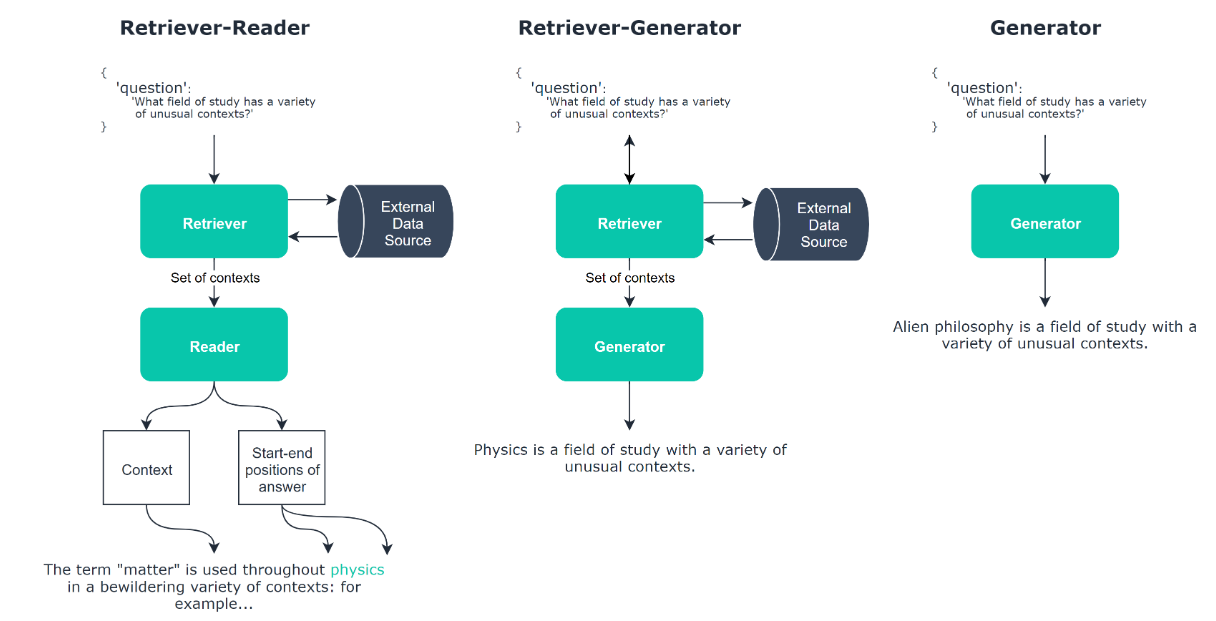

Dataset link :

[SQuAD 2.0 Dataset](https://rajpurkar.github.io/SQuAD-explorer/explore/v2.0/dev/)

In [2]:
import json
import os

with open(os.path.join('/content/train-v2.0.json'), 'rb') as f:
    squad = json.load(f)

In [3]:
squad['data'][0]

{'title': 'Beyoncé',
 'paragraphs': [{'qas': [{'question': 'When did Beyonce start becoming popular?',
     'id': '56be85543aeaaa14008c9063',
     'answers': [{'text': 'in the late 1990s', 'answer_start': 269}],
     'is_impossible': False},
    {'question': 'What areas did Beyonce compete in when she was growing up?',
     'id': '56be85543aeaaa14008c9065',
     'answers': [{'text': 'singing and dancing', 'answer_start': 207}],
     'is_impossible': False},
    {'question': "When did Beyonce leave Destiny's Child and become a solo singer?",
     'id': '56be85543aeaaa14008c9066',
     'answers': [{'text': '2003', 'answer_start': 526}],
     'is_impossible': False},
    {'question': 'In what city and state did Beyonce  grow up? ',
     'id': '56bf6b0f3aeaaa14008c9601',
     'answers': [{'text': 'Houston, Texas', 'answer_start': 166}],
     'is_impossible': False},
    {'question': 'In which decade did Beyonce become famous?',
     'id': '56bf6b0f3aeaaa14008c9602',
     'answers': [{'text

In [4]:
squad['data'][0]['paragraphs'][0]

{'qas': [{'question': 'When did Beyonce start becoming popular?',
   'id': '56be85543aeaaa14008c9063',
   'answers': [{'text': 'in the late 1990s', 'answer_start': 269}],
   'is_impossible': False},
  {'question': 'What areas did Beyonce compete in when she was growing up?',
   'id': '56be85543aeaaa14008c9065',
   'answers': [{'text': 'singing and dancing', 'answer_start': 207}],
   'is_impossible': False},
  {'question': "When did Beyonce leave Destiny's Child and become a solo singer?",
   'id': '56be85543aeaaa14008c9066',
   'answers': [{'text': '2003', 'answer_start': 526}],
   'is_impossible': False},
  {'question': 'In what city and state did Beyonce  grow up? ',
   'id': '56bf6b0f3aeaaa14008c9601',
   'answers': [{'text': 'Houston, Texas', 'answer_start': 166}],
   'is_impossible': False},
  {'question': 'In which decade did Beyonce become famous?',
   'id': '56bf6b0f3aeaaa14008c9602',
   'answers': [{'text': 'late 1990s', 'answer_start': 276}],
   'is_impossible': False},
  {'q

In [5]:
squad['data'][-1]['paragraphs'][0]

{'qas': [{'plausible_answers': [{'text': 'ordinary matter composed of atoms',
     'answer_start': 50}],
   'question': 'What did the term matter include after the 20th century?',
   'id': '5a7db48670df9f001a87505f',
   'answers': [],
   'is_impossible': True},
  {'plausible_answers': [{'text': 'matter', 'answer_start': 59}],
   'question': 'What are atoms composed of?',
   'id': '5a7db48670df9f001a875060',
   'answers': [],
   'is_impossible': True},
  {'plausible_answers': [{'text': 'light or sound', 'answer_start': 128}],
   'question': 'What are two examples of matter?',
   'id': '5a7db48670df9f001a875061',
   'answers': [],
   'is_impossible': True},
  {'plausible_answers': [{'text': "its (possibly massless) constituents' motion and interaction energies",
     'answer_start': 315}],
   'question': "What can an object's mass not come from?",
   'id': '5a7db48670df9f001a875062',
   'answers': [],
   'is_impossible': True},
  {'plausible_answers': [{'text': 'fundamental', 'answer_sta

If we compare the first entry on Beyonce and the second on Matter, we can see that we sometimes return our answers in the 'answers' key, and sometimes in the 'plausible_answers' key.

**Datset creation :**create a format that consists of a list of dictionaries where each dictionary contains a single question, answer, and context.

In [6]:
# initialize list where we will place all of our data
new_squad = []

# we need to loop through groups -> paragraphs -> qa_pairs
for group in squad['data']:
    for paragraph in group['paragraphs']:
        # we pull out the context from here
        context = paragraph['context']
        for qa_pair in paragraph['qas']:
            # we pull out the question
            question = qa_pair['question']
            # now the logic to check if we have 'answers' or 'plausible_answers'
            if 'answers' in qa_pair.keys() and len(qa_pair['answers']) > 0:
                answer = qa_pair['answers'][0]['text']
            elif 'plausible_answers' in qa_pair.keys() and len(qa_pair['plausible_answers']) > 0:
                answer = qa_pair['plausible_answers'][0]['text']
            else:
                # this shouldn't happen, but just in case we just set answer = None
                answer = None
            # append dictionary sample to parsed squad
            new_squad.append({
                'question': question,
                'answer': answer,
                'context': context
            })

In [7]:
new_squad[:2], new_squad[-2:]

([{'question': 'When did Beyonce start becoming popular?',
   'answer': 'in the late 1990s',
   'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".'},
  {'question': 'What areas did Beyonce compete in when she was growing up?',
   'answer': 'singing and dancing',
   'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born

In [8]:
with open(os.path.join('train.json'), 'w') as f:
    json.dump(new_squad, f)

# Validation Parse

Here we apply the same parsing logic that we applied to our training data, to our validation data.

In [9]:
import os
import json

with open(os.path.join('/content/dev-v2.0.json'), 'rb') as f:
    squad = json.load(f)

In [10]:
squad['data'][0]['paragraphs'][0]

{'qas': [{'question': 'In what country is Normandy located?',
   'id': '56ddde6b9a695914005b9628',
   'answers': [{'text': 'France', 'answer_start': 159},
    {'text': 'France', 'answer_start': 159},
    {'text': 'France', 'answer_start': 159},
    {'text': 'France', 'answer_start': 159}],
   'is_impossible': False},
  {'question': 'When were the Normans in Normandy?',
   'id': '56ddde6b9a695914005b9629',
   'answers': [{'text': '10th and 11th centuries', 'answer_start': 94},
    {'text': 'in the 10th and 11th centuries', 'answer_start': 87},
    {'text': '10th and 11th centuries', 'answer_start': 94},
    {'text': '10th and 11th centuries', 'answer_start': 94}],
   'is_impossible': False},
  {'question': 'From which countries did the Norse originate?',
   'id': '56ddde6b9a695914005b962a',
   'answers': [{'text': 'Denmark, Iceland and Norway', 'answer_start': 256},
    {'text': 'Denmark, Iceland and Norway', 'answer_start': 256},
    {'text': 'Denmark, Iceland and Norway', 'answer_star

In [11]:
squad['data'][-1]['paragraphs'][0]

{'qas': [{'question': 'What concept did philosophers in antiquity use to study simple machines?',
   'id': '573735e8c3c5551400e51e71',
   'answers': [{'text': 'force', 'answer_start': 46},
    {'text': 'force', 'answer_start': 46},
    {'text': 'the concept of force', 'answer_start': 31},
    {'text': 'the concept of force', 'answer_start': 31},
    {'text': 'force', 'answer_start': 46},
    {'text': 'force', 'answer_start': 46}],
   'is_impossible': False},
  {'question': 'What was the belief that maintaining motion required force?',
   'id': '573735e8c3c5551400e51e72',
   'answers': [{'text': 'fundamental error', 'answer_start': 387},
    {'text': 'A fundamental error', 'answer_start': 385},
    {'text': 'A fundamental error', 'answer_start': 385},
    {'text': 'A fundamental error', 'answer_start': 385},
    {'text': 'A fundamental error', 'answer_start': 385},
    {'text': 'A fundamental error', 'answer_start': 385}],
   'is_impossible': False},
  {'question': 'Who had mathmatical 

In [12]:
# initialize list where we will place all of our data
new_squad = []

# we need to loop through groups -> paragraphs -> qa_pairs
for group in squad['data']:
    for paragraph in group['paragraphs']:
        # we pull out the context from here
        context = paragraph['context']
        for qa_pair in paragraph['qas']:
            # we pull out the question
            question = qa_pair['question']
            # now the logic to check if we have 'answers' or 'plausible_answers'
            if 'answers' in qa_pair.keys() and len(qa_pair['answers']) > 0:
                answer_list = qa_pair['answers']
            elif 'plausible_answers' in qa_pair.keys() and len(qa_pair['plausible_answers']) > 0:
                answer_list = qa_pair['plausible_answers']
            else:
                # this shouldn't happen, but just in case we just set answer = []
                answer_list = []
            # we want to pull our the 'text' of each answer in our list of answers
            answer_list = [item['text'] for item in answer_list]
            # we can remove duplicate answers by converting our list to a set, and then back to a list
            answer_list = list(set(answer_list))
            # we iterate through each unique answer in the answer_list
            for answer in answer_list:
                # append dictionary sample to parsed squad
                new_squad.append({
                    'question': question,
                    'answer': answer,
                    'context': context
                })

In [13]:
new_squad[:3], new_squad[-2:]

([{'question': 'In what country is Normandy located?',
   'answer': 'France',
   'context': 'The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.'},
  {'question': 'When were the Normans in Normandy?',
   'answer': 'in the 10th and 11th centuries',
   'context': 'The Normans (Norman: Nourmands; French: Norman

In [14]:
with open(os.path.join('dev.json'), 'w') as f:
    json.dump(new_squad, f)

# QA Model

**Question-Answering pipeline** using HuggingFace transformers and a pretrained BERT model. We will be testing it on our SQuAD data.

In [15]:
import json

with open('/content/dev.json', 'r') as f:
    squad = json.load(f)

We initialize our transformer tokenizer and model. This time, we will be using a BERT model that has been trained for question-and-answering on the SQuAD dataset. Which is why we will be using the validation dataset (rather than training dataset) from SQuAD.

In [17]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.7 MB/s eta 0:00:00


In [18]:
from transformers import BertTokenizer, BertForQuestionAnswering

modelname = 'deepset/bert-base-cased-squad2'

tokenizer = BertTokenizer.from_pretrained(modelname)
model = BertForQuestionAnswering.from_pretrained(modelname)

Some weights of the model checkpoint at deepset/bert-base-cased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Transformers comes with a useful class called pipeline which allows us to setup easy to use pipelines for common architectures.

One of those pipelines is the question-answering pipeline which allows us to feed a dictionary containing a 'question' and 'context' and return an answer. Which we initialize like so:

In [19]:
from transformers import pipeline

qa = pipeline('question-answering', model=model, tokenizer=tokenizer)

In [20]:
squad[:2]

[{'question': 'In what country is Normandy located?',
  'answer': 'France',
  'context': 'The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.'},
 {'question': 'When were the Normans in Normandy?',
  'answer': 'in the 10th and 11th centuries',
  'context': 'The Normans (Norman: Nourmands; French: Normands; La

In [21]:
# we will intialize a list for answers
answers = []

for pair in squad[:5]:
    # pass in our question and context to return an answer
    ans = qa({
        'question': pair['question'],
        'context': pair['context']
    })
    # append predicted answer and real to answers list
    answers.append({
        'predicted': ans['answer'],
        'true': pair['answer']
    })

In [22]:
answers

[{'predicted': 'France.', 'true': 'France'},
 {'predicted': '10th and 11th centuries',
  'true': 'in the 10th and 11th centuries'},
 {'predicted': '10th and 11th centuries', 'true': '10th and 11th centuries'},
 {'predicted': 'Denmark, Iceland and Norway',
  'true': 'Denmark, Iceland and Norway'},
 {'predicted': 'Rollo,', 'true': 'Rollo'}]